
# EVs - modeling 

goal: model the impact of EVs on the grid

In [2]:
## Necessaries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import json
import requests
from datetime import datetime
from datetime import timedelta
import random

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Metadata on EVs and their usage

In [3]:
## data on EV adoption from: https://www.bfs.admin.ch/bfs/en/home/statistics/mobility-transport/transport-infrastructure-vehicles/vehicles/road-vehicles-stock-level-motorisation.html

## Decide the consrtaint for the number of different vehicles present in 2050

Ideas:
- could show the variation of EVs over Switzerland (for different cantons) and over time
- be able to play with the constraints => different scenarios 

## Estimate the evolution of numbers EVs in Switzerland and the technology

In [4]:
data = pd.read_csv('data/ev_data.csv', encoding='ISO-8859-1')
data["Canton"].unique()


array(['Switzerland', 'Zürich', 'Bern', 'Luzern', 'Uri', 'Schwyz',
       'Obwalden', 'Nidwalden', 'Glarus', 'Zug', 'Fribourg', 'Solothurn',
       'Basel-Stadt', 'Basel-Landschaft', 'Schaffhausen',
       'Appenzell-Ausserrhoden', 'Appenzell-Innerrhoden', 'Sankt Gallen',
       'Graubünden', 'Aargau', 'Thurgau', 'Ticino', 'Vaud', 'Valais',
       'Neuchâtel', 'Genève', 'Jura', 'Confederation'], dtype=object)

In [5]:
data.head()

,Canton,Vehicle group / type,Fuel,1990,1991,1992,1993,1994,1995,1996,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Switzerland,> Passenger cars,Petrol,2905762,2975154,3006666,3022762,3073062,3132238,3166299,...,3234560,3201710,3173806,3149902,3127023,3114726,3099442,3087390,3054773,2991092
1,Switzerland,> Passenger cars,Diesel,79129,81883,83640,85703,90747,95585,100412,...,1035843,1123676,1214075,1291500,1346938,1374246,1382645,1379077,1360111,1319337
2,Switzerland,> Passenger cars,Electricity,409,671,771,774,775,770,759,...,2683,4439,7531,10724,14539,19181,28716,43396,71697,110751
3,Switzerland,> Passenger cars,Other,97,90,151,284,458,583,623,...,47799,54665,62657,71903,82323,94535,113149,148472,222785,300100
4,Switzerland,> Passenger cars,Without motor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def process_data(df:  pd.core.frame.DataFrame)  -> pd.DataFrame:
    ## Function to keep useful information from the data 
    df = df[(df["Canton"] == "Switzerland") & (df["Vehicle group / type"] == "> Passenger cars")].drop(columns=['Canton', 'Vehicle group / type'])
    df.set_index('Fuel', inplace=True)
    df = df.T
    df.drop(columns=["Without motor"], inplace=True)
    df.rename(columns={'Other': 'hybrid', 'Electricity': 'battery_electric'}, inplace=True)
    df["total_car"] = df.sum(axis=1)
    df['Year'] = df.index
    df = df.reset_index(drop=True)
    return df


In [7]:
def plot_evolution(df: pd.core.frame.DataFrame) -> None:
    plt.figure(figsize=(15, 8))
    
    sns.lineplot(data=df, x='Year', y='Petrol', label='Petrol')
    sns.lineplot(data=df, x='Year', y='Diesel', label='Diesel')
    sns.lineplot(data=df, x='Year', y='hybrid', label='Hybrid')
    sns.lineplot(data=df, x='Year', y='battery_electric', label='Battery electric')
    sns.lineplot(data=df, x='Year', y='total_car', label='Total')
    
    # Set the x-ticks and labels for every 2 years
    x_ticks = df['Year'].unique()[::2]
    x_tick_labels = [str(year) for year in x_ticks]
    
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    

    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Number of cars')
    plt.title('Evolution of the number of cars in Switzerland over years')
    plt.show()

In [8]:
class forecast_number_car():
    def __init__(self, df : pd.DataFrame, year_constraint, petrol_constraint, diesel_constraint, hybrid_constraint, battery_elecrtic_constraint, pol_degree, weights = "exp") -> None:
        self.df = df
        self.year_constraint = year_constraint
        self.end_year = self.df["Year"].astype(int).max()
        self.petrol_constraint = petrol_constraint
        self.diesel_constraint = diesel_constraint
        self.hybrid_constraint = hybrid_constraint
        self.battery_elecrtic_constraint = battery_elecrtic_constraint
        self.pol_degree = pol_degree
        self.weights = weights
        self.__df_constraint()
        self.__polynomial_regression()
        self.__concat_df()

    def __df_constraint(self) -> pd.DataFrame:
        total_car_constraint = self.petrol_constraint + self.diesel_constraint + self.hybrid_constraint + self.battery_elecrtic_constraint
        intercept_value = pd.DataFrame({"Year": self.year_constraint, "Petrol": self.petrol_constraint, "Diesel": self.diesel_constraint, "hybrid": self.hybrid_constraint, "battery_electric": self.battery_elecrtic_constraint, "total_car": total_car_constraint}, index=[0])
        self.df = pd.concat([self.df, intercept_value], ignore_index=True)

    def __polynomial_regression(self) -> pd.DataFrame:

        if self.weights == "exp":
            weights = np.exp(np.linspace(-10, 0, len(self.df)))
        else:
            weights = np.linspace(0, 1, len(self.df))

        self.data_ev_forecast = pd.DataFrame({'Year': list(range(self.end_year, self.year_constraint))})

        # Create a loop to perform polynomial regression for each column
        for col in self.df.columns:
            if col == 'Year':
                continue  # Skip the 'Year' column
    
            # Create polynomial features
            poly = PolynomialFeatures(degree=self.pol_degree)
            X_poly = poly.fit_transform(self.df[['Year']])
    
            # Create a linear regression model
            model = LinearRegression()
    
            # Fit the model to the polynomial features for the current column
            model.fit(X_poly, self.df[col], sample_weight=weights)
    
            # Forecast future values for each year from 2024 to 2050
            years_forecast = list(range(self.end_year, self.year_constraint))
            future_years_poly = poly.transform(np.array(years_forecast).reshape(-1, 1))
            predictions = model.predict(future_years_poly)
    
            # Create a new column with the predicted values and add it to the DataFrame
            self.data_ev_forecast[col] = predictions

    def __concat_df(self) -> pd.DataFrame:
        self.df = pd.concat([self.df, self.data_ev_forecast], ignore_index=True)
        self.df = self.df.astype({'Year': str})
        self.df = self.df.sort_values(by=['Year'])

    def get_df(self) -> pd.DataFrame:
        return self.df
    

In [9]:
data_ev = process_data(data)
data_ev.head()

Fuel,Petrol,Diesel,battery_electric,hybrid,total_car,Year
0,2905762,79129,409,97,2985397,1990
1,2975154,81883,671,90,3057798,1991
2,3006666,83640,771,151,3091228,1992
3,3022762,85703,774,284,3109523,1993
4,3073062,90747,775,458,3165042,1994


/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

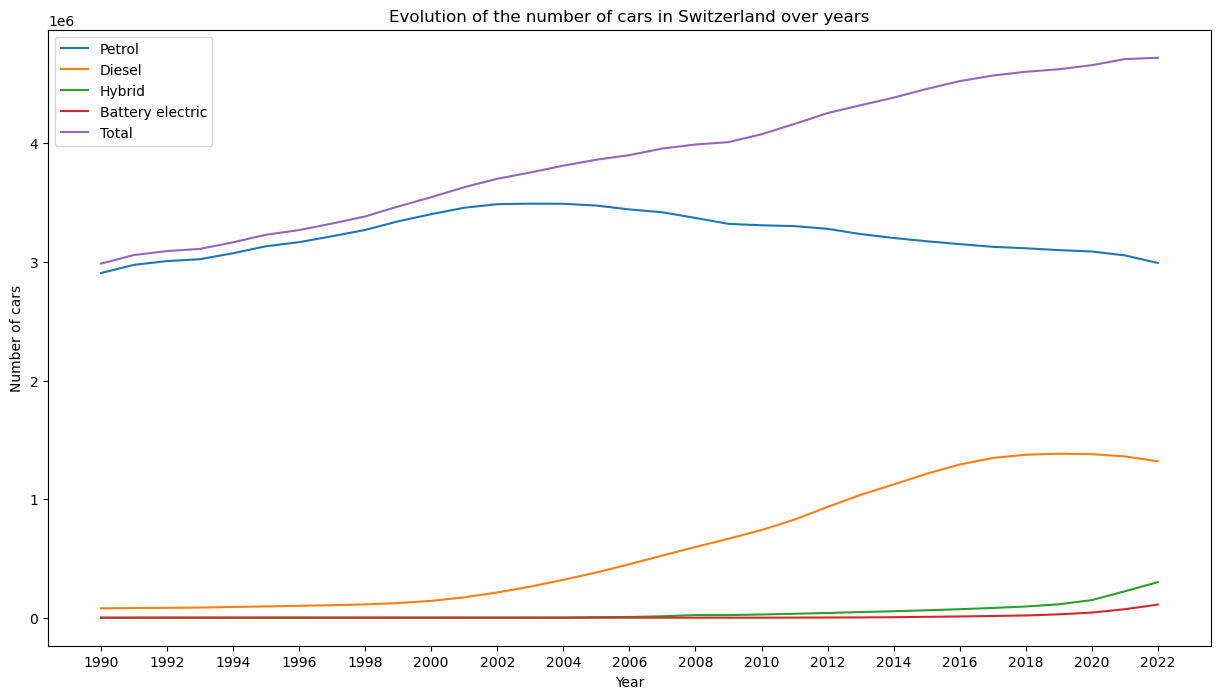

In [10]:
# Plot the evolution of the number of cars in Switzerland over years from historical data

plot_evolution(data_ev)

In [11]:
# Forecasting the number of cars in Switzerland with a plynomial regression model up to 2050

data_ev_forecast = forecast_number_car(data_ev, year_constraint=2050, petrol_constraint=10000, diesel_constraint=0 , hybrid_constraint = 5e6, battery_elecrtic_constraint=1e6, pol_degree=3, weights = "exp").get_df()
data_ev_forecast.tail()

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
58,754353.650330,330682.414185,835389.266342,3.823413e+06,5.743852e+06,2046
59,580752.102356,250535.464661,875876.616821,4.098635e+06,5.805813e+06,2047
60,398975.319519,168524.371521,916849.656433,4.386325e+06,5.870690e+06,2048
61,208818.421326,84774.525574,958275.834351,4.686748e+06,5.938633e+06,2049
33,10000.000000,0.000000,1000000.000000,5.000000e+06,6.010000e+06,2050


/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

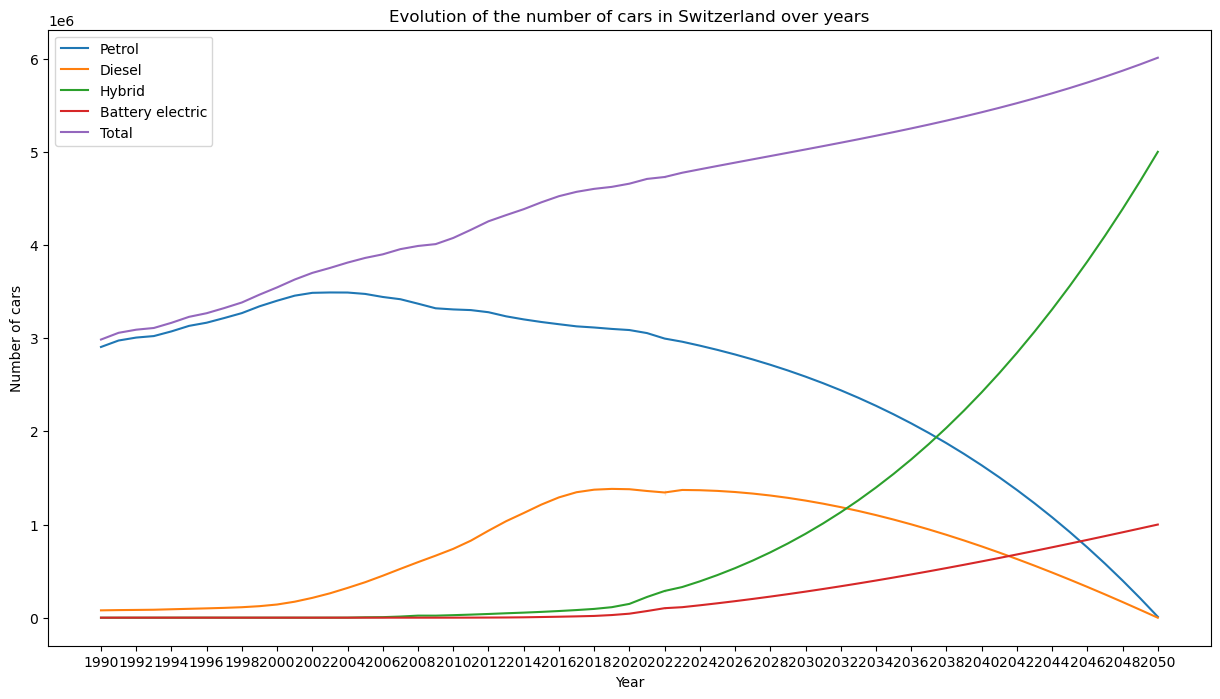

In [12]:
plot_evolution(data_ev_forecast)

## Model the distibution of charging start time over a day 

In [13]:
# Loading and creating a dataframe with the different charging events from Caltech

with open('data/acndata_sessions.json', 'r') as file:        data = json.load(file)

items = data["_items"]

# Create a list of dictionaries with the desired columns
data_list = []
for item in items:
    data_list.append({
        "connection_time": item["connectionTime"],
        "done_charging_time": item["doneChargingTime"],
        "kwh_delivered": item["kWhDelivered"]
    })

print("number of charging events: {}".format(len(data["_items"])))
# Create a DataFrame
data_charging = pd.DataFrame(data_list)
# Create a new column with just the time of the day

data_charging["hour"] = pd.to_datetime(data_charging["connection_time"]).dt.strftime('%H:%M')

data_charging['15_min_interval'] = pd.to_datetime(data_charging['connection_time']).apply(lambda x: x - timedelta(minutes=x.minute % 15, seconds=x.second, microseconds=x.microsecond)).dt.strftime('%H:%M')
event_counts = data_charging.groupby('15_min_interval').size().reset_index(name='event_count')
event_counts["probability"] = event_counts["event_count"] / event_counts["event_count"].sum()

number of charging events: 17798


In [14]:
data_charging.head()

,connection_time,done_charging_time,kwh_delivered,hour,15_min_interval
0,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,11:08,11:00
1,"Wed, 25 Apr 2018 13:45:10 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,13:45,13:45
2,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,13:45,13:45
3,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,14:37,14:30
4,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,14:40,14:30


In [15]:
def visualize_kwh_delivered(df):
    df = df.sort_values(by=['kwh_delivered'], ascending=False).reset_index(drop=True).copy()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df,x = df.index, y='kwh_delivered')
    plt.xticks(rotation=90)
    plt.xlabel('Hour of the day')
    plt.ylabel('kwh delivered')
    plt.title('kwh delivered over the day')
    plt.show()

In [16]:
random_kwh = data_charging.sample(n=1)["kwh_delivered"]
random_kwh

11919    2.176
Name: kwh_delivered, dtype: float64

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

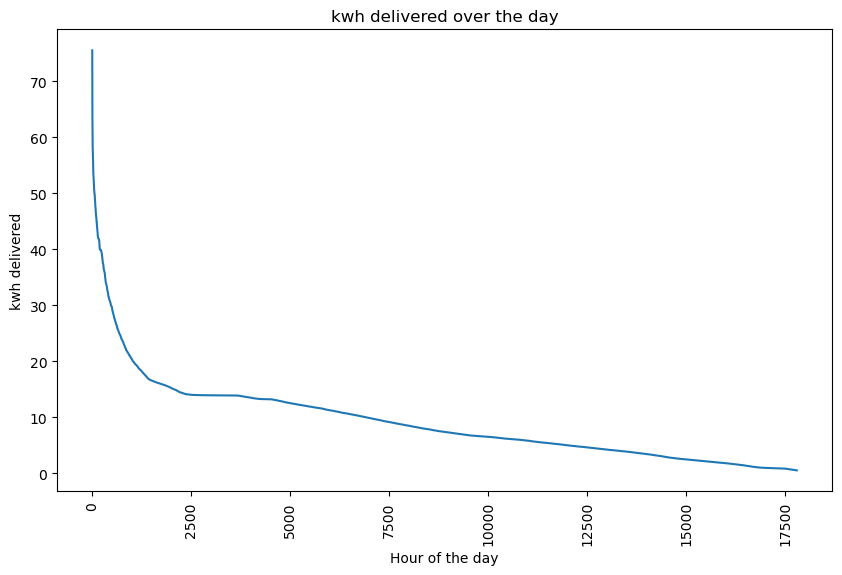

In [17]:
# plot the number of kwh_delivered

visualize_kwh_delivered(data_charging)

In [18]:

event_counts.head()

,15_min_interval,event_count,probability
0,00:00,215,0.012080
1,00:15,223,0.012529
2,00:30,217,0.012192
3,00:45,198,0.011125
4,01:00,214,0.012024


In [19]:
sampled_time = np.random.choice(event_counts['15_min_interval'], p=event_counts['probability'])
sampled_time

'19:45'

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

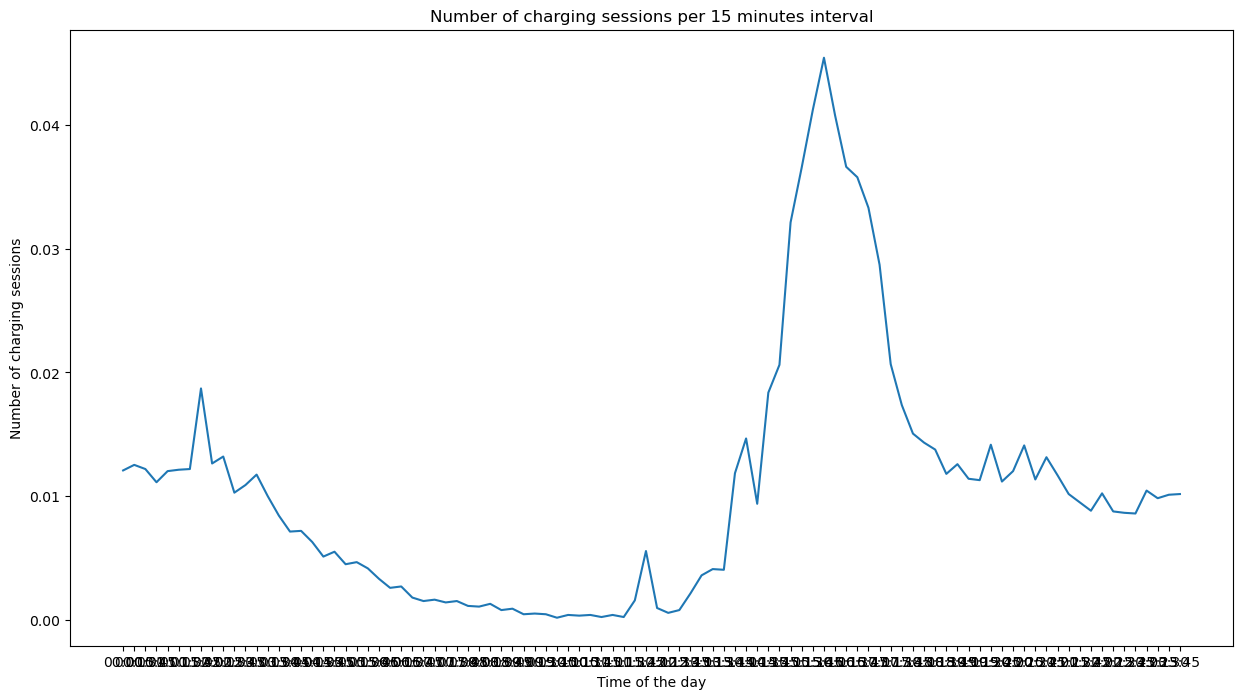

In [20]:
## Plot the number of charging sessions per 15 minutes interval

plt.figure(figsize=(15, 8))
sns.lineplot(data=event_counts, x='15_min_interval', y='probability')
plt.xlabel('Time of the day')
plt.ylabel('Number of charging sessions')
plt.title('Number of charging sessions per 15 minutes interval')
plt.show()

## Model the constraints of user and from charging 

In [21]:
def round_time_15(original_time: datetime) -> datetime:
    # Calculate the rounded time to the nearest quarter-hour
    rounded_time = (original_time + timedelta(minutes=7.5)).replace(second=0, microsecond=0, minute=(original_time.minute // 15) * 15)
    return rounded_time

In [22]:
def model_charging(start_charging_time, required_energy, power_charge):
    '''
    Situation with no flexibility
    This function model the charging of an EV with a given power and a given required energy when just charging when plugged in
    :input: start_charging_time: datetime object
    :input: required_energy: float
    :input: power_charge: float
    :output: df: DataFrame with the time and the power'''
    start_time = pd.Timestamp("00:00")
    end_time = pd.Timestamp("23:59")
    time_intervals = pd.date_range(start_time, end_time, freq='15T').time

    # Create a DataFrame with 'time' and 'power' columns
    df = pd.DataFrame({'time': time_intervals, 'power': 0})

    round_start_time = round_time_15(start_charging_time)
    
    # Calculate the number of 15-minute intervals required to charge the car
    intervals = int(np.ceil((required_energy*4) / power_charge))
    # print("number of intervals: {}".format(intervals))

    # Calculate the end time
    end_charging_time = round_start_time + timedelta(minutes=15*intervals)

    # print("time of end charging: {}".format(end_charging_time))

    # deals with the case when the charging as to end the next day
    if end_charging_time.date() > round_start_time.date():
        df.loc[df['time'] < end_charging_time.time(), 'power'] = power_charge
        df.loc[df['time'] >= round_start_time.time(), 'power'] = power_charge

    else:
        df.loc[(df['time'] >= round_start_time.time()) & (df['time'] < end_charging_time.time()), 'power'] = power_charge

    return df    

In [23]:
def sample_random_charging_event(data_charging, event_counts):
    sampled_time = np.random.choice(event_counts['15_min_interval'], p=event_counts['probability'])
    random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])
    return datetime.strptime(sampled_time, '%H:%M'), random_kwh

In [24]:
sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)
print("sampled time: {}".format(sampled_time))
print("random kwh: {}".format(random_kwh))

sampled time: 1900-01-01 16:30:00
random kwh: 3.463


/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])


In [25]:
test = model_charging(datetime.strptime("21:00", "%H:%M"), 8, 4)
test

,time,power
0,00:00:00,0
1,00:15:00,0
2,00:30:00,0
3,00:45:00,0
4,01:00:00,0
...,...,...
91,22:45:00,4
92,23:00:00,0
93,23:15:00,0
94,23:30:00,0


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Ser

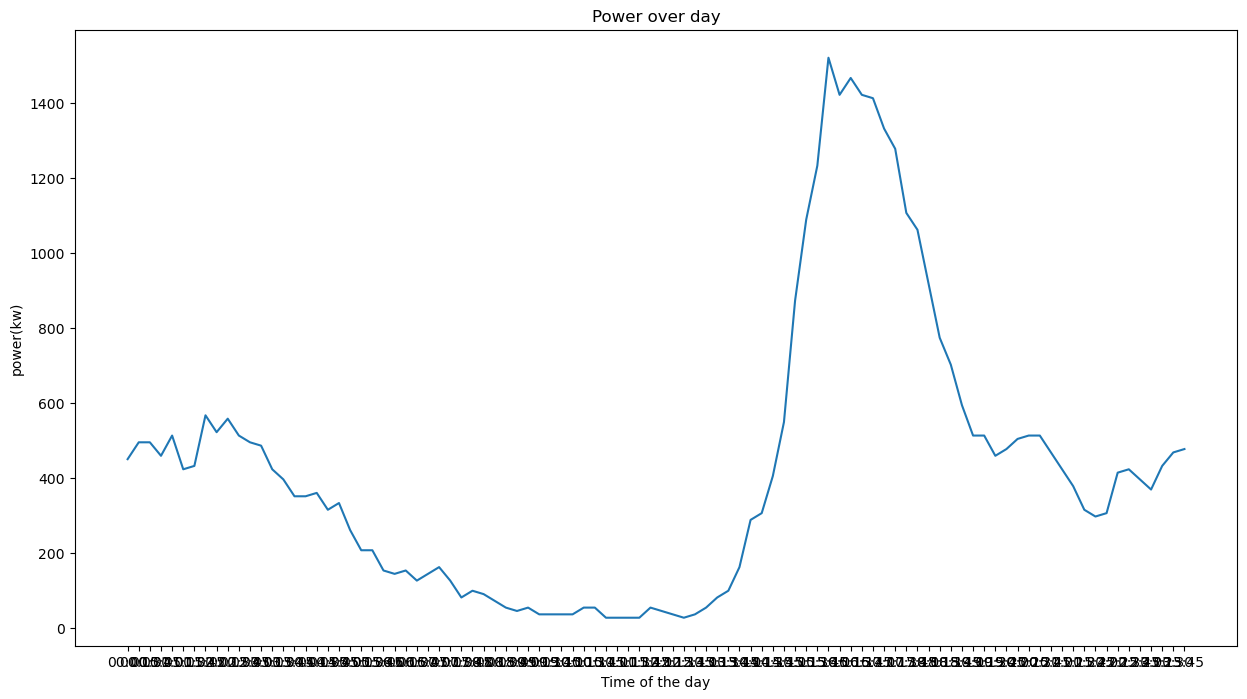

In [26]:
number_samples = 1000

for sample in tqdm(range(number_samples)):
    sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)
    df = model_charging(sampled_time, random_kwh, 9)
    if sample == 0:
        df_final = df.copy()
    else:
        df_final["power"] = df_final["power"] + df["power"]

df_final['time_as_string'] = df_final['time'].apply(lambda x: x.strftime('%H:%M'))

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final, x='time_as_string', y='power')
plt.xlabel('Time of the day')
plt.ylabel('power(kw)')
plt.title('Power over day')
plt.show()

In [27]:
df_final['time_as_string'] = df_final['time'].apply(lambda x: x.strftime('%H:%M'))
df_final

,time,power,time_as_string
0,00:00:00,450,00:00
1,00:15:00,495,00:15
2,00:30:00,495,00:30
3,00:45:00,459,00:45
4,01:00:00,513,01:00
...,...,...,...
91,22:45:00,396,22:45
92,23:00:00,369,23:00
93,23:15:00,432,23:15
94,23:30:00,468,23:30


/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

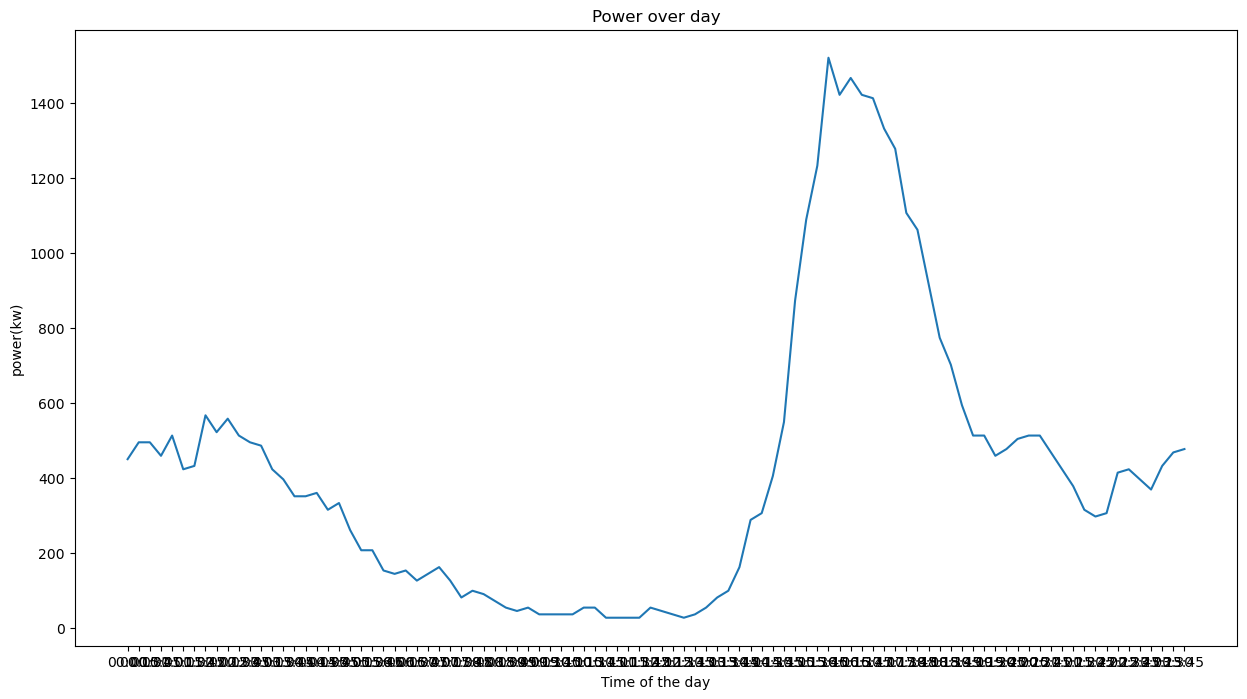

In [28]:
# plot power over day from df


plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final, x='time_as_string', y='power')
plt.xlabel('Time of the day')
plt.ylabel('power(kw)')
plt.title('Power over day')
plt.show()

In [29]:
def model_charging_constraint(start_charging_time, required_energy, power_charge):
    '''
    Function to model the constraint for the charging habits of the swiss population
    :input: start_charging_time: datetime object
    :return: end_charging_constraint: datetime object
    '''
    # If the charging start after 16h00 we can hipothetize that the car has to be charged latest at 7h00 (case of people charging at home)
    # If the charging start after 7h00 we can hipothetize that the car has to be charged latest at 16h00 (case of people charging at work)
    # If the charging can not finish before 7h00 or 16h00 then we hipothesizee that the car has to be charged in 3 hours. If it does not have the time then it has to charge as fast as possible

    delta_hours = 3
    if start_charging_time.hour >= 16 or start_charging_time.hour < 4:
        end_charging_constraint = datetime.strptime("7:00", "%H:%M")
        delta = (datetime.strptime("4:00", "%H:%M") - start_charging_time).seconds/3600
        if required_energy >= power_charge*delta_hours or required_energy >= power_charge*delta:
            end_charging_constraint = start_charging_time + timedelta(hours=required_energy/power_charge)
    elif start_charging_time.hour >= 7 and start_charging_time.hour < 15:
        end_charging_constraint = datetime.strptime("16:00", "%H:%M")
        delta = (datetime.strptime("16:00", "%H:%M") - start_charging_time).seconds/3600
        if required_energy >= power_charge*delta_hours or required_energy >= power_charge*delta:
            end_charging_constraint = start_charging_time + timedelta(hours=required_energy/power_charge)
    else:
        end_charging_constraint = start_charging_time + timedelta(hours=delta_hours)
        

    # Format the datetime object as a string in "%H:%M" format
    end_charging_constraint_str = end_charging_constraint.strftime("%H:%M")
    
    return end_charging_constraint
        

In [30]:
model_charging_constraint(datetime.strptime("14:30", "%H:%M"), 16, 9)

datetime.datetime(1900, 1, 1, 16, 16, 40)

In [31]:
(datetime.strptime("7:00", "%H:%M") - datetime.strptime("5:00", "%H:%M")).seconds / 3600

2.0

In [32]:
sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)
print("sampled time: {}".format(sampled_time))
print("random kwh: {}".format(random_kwh))

sampled time: 1900-01-01 14:30:00
random kwh: 5.818191457585611


/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])


In [33]:
# create a dataframe with certain column names 

df_test = pd.DataFrame(columns=['car', 'plug_in_time', 'be_charged', 'pluged', 'energy_needed', 'power'])
power = 3
sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)
df_test.loc[len(df_test)] = [1, sampled_time, model_charging_constraint(datetime.strptime("5:00", "%H:%M"), random_kwh, power), False, random_kwh, power]
df_test

/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])


,car,plug_in_time,be_charged,pluged,energy_needed,power
0,1,1900-01-01 02:15:00,1900-01-01 08:00:00,False,10.826,3


In [34]:
def model_charging_average(plug_in_time, be_charged, energy_needed, power):
    '''
    Function to model the charging of an EV with a given power and a given required energy when just charging when plugged in
    :input: plug_in_time: datetime object
    :input: be_charged: datetime object
    :input: energy_needed: float
    :input: power: float
    :output: df: DataFrame with the time and the power'''
    start_time = pd.Timestamp("00:00")
    end_time = pd.Timestamp("23:59")
    time_intervals = pd.date_range(start_time, end_time, freq='15T').time

    # Create a DataFrame with 'time' and 'power' columns
    df = pd.DataFrame({'time': time_intervals, 'power': 0})

    round_start_time = round_time_15(plug_in_time)
    round_end_time = round_time_15(be_charged)
    averaged_power = energy_needed / (round_end_time - round_start_time).seconds * 3600

    # Deal with the case when the time alocated is not enough to charge the car
    # We need ot push the round_end_time 
    if averaged_power > power:
        averaged_power = power
        round_end_time = round_start_time + timedelta(hours=energy_needed/power)

    # deals with the case when the charging as to end the next day
    if round_end_time.date() > round_start_time.date():
        df.loc[df['time'] < round_end_time.time(), 'power'] = averaged_power
        df.loc[df['time'] >= round_start_time.time(), 'power'] = averaged_power

    # deals with the case when the charging as to end the next day
    if round_end_time.time() < round_start_time.time():
        df.loc[df['time'] < round_end_time.time(), 'power'] = averaged_power
        df.loc[df['time'] >= round_start_time.time(), 'power'] = averaged_power

    else:
        df.loc[(df['time'] >= round_start_time.time()) & (df['time'] < round_end_time.time()), 'power'] = averaged_power

    return df

In [35]:
test = model_charging_average(datetime.strptime("21:30", "%H:%M"), datetime.strptime("0:30", "%H:%M"),5, 4)
test

/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/2037594963.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.6666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['time'] < round_end_time.time(), 'power'] = averaged_power


,time,power
0,00:00:00,1.666667
1,00:15:00,1.666667
2,00:30:00,0.000000
3,00:45:00,0.000000
4,01:00:00,0.000000
...,...,...
91,22:45:00,1.666667
92,23:00:00,1.666667
93,23:15:00,1.666667
94,23:30:00,1.666667


In [341]:
# Initialize DataFrame
df_test = pd.DataFrame(columns=['car', 'plug_in_time', 'be_charged', 'pluged', 'energy_needed', 'power', 'last_time_to_charge'])

# Example parameters
power = 9

car_number = 1000
# Loop over cars
for car_number in range(1, car_number + 1):  # Assuming 5 cars for example
    # Sample charging event
    sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)

    # Model charging constraint and add row to DataFrame
    df_test = pd.concat([df_test, pd.DataFrame([{
        'car': car_number,
        'plug_in_time': sampled_time.strftime("%H:%M"),
        'be_charged': round_time_15(model_charging_constraint(sampled_time, random_kwh, power)).strftime("%H:%M"),
        'pluged': False,
        # 'need_to_charge': False
        'energy_needed': random_kwh,
        'power': power,
        'last_time_to_charge': (round_time_15(model_charging_constraint(sampled_time, random_kwh, power) - timedelta(hours=random_kwh / power))).strftime("%H:%M"),
        'time_before_need_to_charge': (round_time_15(model_charging_constraint(sampled_time, random_kwh, power) - timedelta(hours=random_kwh / power)) - sampled_time).seconds / 3600,
        'charge_done': False
    }])], ignore_index=True)

# Display the resulting DataFrame order by time_before_need_to_charge
df_test.sort_values(by=['time_before_need_to_charge'], inplace=True, ascending=False)
df_test

/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/965255791.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, pd.DataFrame([{
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_57428/623180544.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  random_kwh = float(data_charging.sample(n=1)["kwh_delivered"]

,car,plug_in_time,be_charged,pluged,energy_needed,power,last_time_to_charge,time_before_need_to_charge,charge_done
822,823,15:00,18:00,False,28.619000,9,14:45,23.75,False
306,307,15:45,18:45,False,31.274504,9,15:15,23.50,False
751,752,15:15,18:15,False,30.708000,9,14:45,23.50,False
865,866,15:30,18:30,False,29.828000,9,15:00,23.50,False
774,775,15:45,18:45,False,33.720000,9,15:00,23.25,False
...,...,...,...,...,...,...,...,...,...
165,166,03:45,04:15,False,6.334000,9,03:45,0.00,False
548,549,03:45,04:15,False,6.089000,9,03:45,0.00,False
941,942,14:45,16:30,False,15.950000,9,14:45,0.00,False
407,408,14:45,16:15,False,13.759000,9,14:45,0.00,False


In [342]:
# Initialize DataFrame
# We are going to use this dataframe to store the power of each car at each time interval
# We will need to define it over 2 days to deal with the case when the car is plugged in the next day

num_cars = 1000

start_time = pd.Timestamp("00:00")
end_time = pd.Timestamp("23:59")
date_range = pd.date_range(start_time, end_time, freq='15T').time

# Convert time objects to string format "h:mm"
time_strings = [time.strftime('%H:%M') for time in date_range]

columns = ["car_" + str(i) for i in range(1, num_cars + 1)] + ["total", "up", "down"]
df = pd.DataFrame(columns=columns, index=time_strings)

# Populate the DataFrame with 0 for each column
for time in time_strings:
    row_data = {col: 0 for col in columns}
    
    # Append the row to the DataFrame
    df.loc[time] = row_data

df = pd.concat([df, df], axis=0)

In [343]:
df

,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8,car_9,car_10,...,car_994,car_995,car_996,car_997,car_998,car_999,car_1000,total,up,down
00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [344]:
df_test

# add charged column to df_test

,car,plug_in_time,be_charged,pluged,energy_needed,power,last_time_to_charge,time_before_need_to_charge,charge_done
822,823,15:00,18:00,False,28.619000,9,14:45,23.75,False
306,307,15:45,18:45,False,31.274504,9,15:15,23.50,False
751,752,15:15,18:15,False,30.708000,9,14:45,23.50,False
865,866,15:30,18:30,False,29.828000,9,15:00,23.50,False
774,775,15:45,18:45,False,33.720000,9,15:00,23.25,False
...,...,...,...,...,...,...,...,...,...
165,166,03:45,04:15,False,6.334000,9,03:45,0.00,False
548,549,03:45,04:15,False,6.089000,9,03:45,0.00,False
941,942,14:45,16:30,False,15.950000,9,14:45,0.00,False
407,408,14:45,16:15,False,13.759000,9,14:45,0.00,False


In [345]:
df_prov = df_test.copy()
for time_interval, row_df in df.iterrows():
    down_regulation = 0
    up_regulation = 0
    print(time_interval)
    for car in range(1, car_number+1):
        # Locating the row with the car number
        row = df_prov.loc[df_prov['car'] == car]
        if df_prov.loc[df_test['car'] == car, "plug_in_time"].item() == time_interval and df_prov.loc[df_test['car'] == car, "charge_done"].item() == False:
            # for now start the charge when plugged in
            df_prov.loc[df_prov['car'] == car, "pluged"] = True
            print("car number {} has been plugged in at {}".format(car, time_interval))
        if df_prov.loc[df_prov['car'] == car, "energy_needed"].item() <= 0 and df_prov.loc[df_prov['car'] == car, "charge_done"].item() == False:
            # unplug the car when no more need to be charged
            print("car number {} has been unplugged at {}".format(car, time_interval))
            df_prov.loc[df_prov['car'] == car, "pluged"] = False
            df_prov.loc[df_prov['car'] == car, "charge_done"] = True
        if df_prov.loc[df_prov['car'] == car, "pluged"].item() == True:
            print("we do update the df")
            # We update the energy needed if the car is charging
            # We take the max in order not too charge more that the energy needed
            df_prov.loc[df_prov['car'] == car, "energy_needed"] = max(df_prov.loc[df_prov['car'] == car, "energy_needed"].item() - df_prov.loc[df_prov['car'] == car, "power"].item()/4,0)
            # print("energy needed: {}".format(df_prov.loc[df_prov['car'] == car, "energy_needed"].item()))
            # Add 15 minute to the last_time_to_charge if the car is charging
            df_prov.loc[df_prov['car'] == car, "last_time_to_charge"] = (datetime.strptime(df_prov.loc[df_prov['car'] == car, "last_time_to_charge"].item(), "%H:%M") + timedelta(minutes=15)).strftime("%H:%M")
            # we need to update the energy used for the 15 minutes interval in df
            # we take the min between the power and the energy needed for the case of end of charge
            row_df["car_" + str(car)] = min(df_prov.loc[df_prov['car'] == car, "power"].item()/4,df_prov.loc[df_prov['car'] == car, "energy_needed"].item())

            if df_prov.loc[df_prov['car'] == car, "time_before_need_to_charge"].item() > 0:
                down_regulation += min(df_prov.loc[df_prov['car'] == car, "power"].item()/4,df_prov.loc[df_prov['car'] == car, "energy_needed"].item())
    row_df["down"] = down_regulation
        # if df_prov.loc[df_prov['car'] == car, "pluged"].item() == True and df_prov.loc[df_prov['car'] == car, "charge_done"].item() == False and "charging":
        #     print("we do update the time before need to charge")
        #     df_prov.loc[df_prov['car'] == car, "time_before_need_to_charge"] = max(df_prov.loc[df_prov['car'] == car, "time_before_need_to_charge"].item() - 0.25,0)

00:00
car number 26 has been plugged in at 00:00
we do update the df
car number 196 has been plugged in at 00:00
we do update the df
car number 275 has been plugged in at 00:00
we do update the df
car number 395 has been plugged in at 00:00
we do update the df
car number 485 has been plugged in at 00:00
we do update the df
car number 609 has been plugged in at 00:00
we do update the df
car number 693 has been plugged in at 00:00
we do update the df
car number 733 has been plugged in at 00:00
we do update the df
car number 734 has been plugged in at 00:00
we do update the df
car number 758 has been plugged in at 00:00
we do update the df
car number 859 has been plugged in at 00:00
we do update the df
car number 916 has been plugged in at 00:00
we do update the df
00:15
we do update the df
car number 33 has been plugged in at 00:15
we do update the df
car number 65 has been plugged in at 00:15
we do update the df
car number 69 has been plugged in at 00:15
we do update the df
we do update

In [307]:
df_prov = df_test.copy()
for time_interval, row_df in df.iterrows():
    # time_interval_str = time_interval.strftime("%H:%M")
    print(time_interval)
    for car in range(1, car_number+1):
        # Locating the row with the car number
        row = df_prov.loc[df_prov['car'] == car]
        if df_prov.loc[df_test['car'] == car, "plug_in_time"].item() == time_interval and df_prov.loc[df_test['car'] == car, "charge_done"].item() == False:
            # for now start the charge when plugged in
            df_prov.loc[df_prov['car'] == car, "pluged"] = True
            print("car number {} has been plugged in at {}".format(car, time_interval))
        if df_prov.loc[df_prov['car'] == car, "energy_needed"].item() <= 0 and df_prov.loc[df_prov['car'] == car, "charge_done"].item() == False:
            # unplug the car when no more need to be charged
            print("car number {} has been unplugged at {}".format(car, time_interval))
            df_prov.loc[df_prov['car'] == car, "pluged"] = False
            df_prov.loc[df_prov['car'] == car, "charge_done"] = True
        if df_prov.loc[df_prov['car'] == car, "pluged"].item() == True:
            print("we do update the df")
            # We update the energy needed if the car is charging
            # We take the max in order not too charge more that the energy needed
            df_prov.loc[df_prov['car'] == car, "energy_needed"] = max(df_prov.loc[df_prov['car'] == car, "energy_needed"].item() - df_prov.loc[df_prov['car'] == car, "power"].item()/4,0)
            # print("energy needed: {}".format(df_prov.loc[df_prov['car'] == car, "energy_needed"].item()))
            # Add 15 minute to the last_time_to_charge if the car is charging
            df_prov.loc[df_prov['car'] == car, "last_time_to_charge"] = (datetime.strptime(df_prov.loc[df_prov['car'] == car, "last_time_to_charge"].item(), "%H:%M") + timedelta(minutes=15)).strftime("%H:%M")
            # we need to update the energy used for the 15 minutes interval in df
            # we take the min between the power and the energy needed for the case of end of charge
            row_df["car_" + str(car)] = min(df_prov.loc[df_prov['car'] == car, "power"].item()/4,df_prov.loc[df_prov['car'] == car, "energy_needed"].item())
        

        # upadate the last time to charge as the difference between the last time to charge and the be_charged time
        df_prov.loc[df_prov['car'] == car, "time_before_need_to_charge"] = (datetime.strptime(df_prov.loc[df_prov['car'] == car, "last_time_to_charge"].item(), "%H:%M") - datetime.strptime(df_prov.loc[df_prov['car'] == car, "be_charged"].item(), "%H:%M")).seconds / 3600
        print("time before need to charge: {}".format(df_prov.loc[df_prov['car'] == car, "time_before_need_to_charge"].item()))

00:00
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
00:15
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
00:30
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
00:45
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
01:00
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
01:15
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
01:30
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
01:45
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
02:00
time before need to charge: 18.5
time before need to charge: 20.25
time before need to charge: 22.25
02:15
time before need to charge: 18.

In [346]:
df_prov

,car,plug_in_time,be_charged,pluged,energy_needed,power,last_time_to_charge,time_before_need_to_charge,charge_done
822,823,15:00,18:00,False,0.0,9,18:00,23.75,True
306,307,15:45,18:45,False,0.0,9,18:45,23.50,True
751,752,15:15,18:15,False,0.0,9,18:15,23.50,True
865,866,15:30,18:30,False,0.0,9,18:30,23.50,True
774,775,15:45,18:45,False,0.0,9,18:45,23.25,True
...,...,...,...,...,...,...,...,...,...
165,166,03:45,04:15,False,0.0,9,04:30,0.00,True
548,549,03:45,04:15,False,0.0,9,04:30,0.00,True
941,942,14:45,16:30,False,0.0,9,16:45,0.00,True
407,408,14:45,16:15,False,0.0,9,16:30,0.00,True


In [96]:
for time_interval in df.index:
    time_interval_str = time_interval.strftime("%H:%M")
    print(type(time_interval_str))
    print(time_interval_str)

<class 'str'>
00:00
<class 'str'>
00:15
<class 'str'>
00:30
<class 'str'>
00:45
<class 'str'>
01:00
<class 'str'>
01:15
<class 'str'>
01:30
<class 'str'>
01:45
<class 'str'>
02:00
<class 'str'>
02:15
<class 'str'>
02:30
<class 'str'>
02:45
<class 'str'>
03:00
<class 'str'>
03:15
<class 'str'>
03:30
<class 'str'>
03:45
<class 'str'>
04:00
<class 'str'>
04:15
<class 'str'>
04:30
<class 'str'>
04:45
<class 'str'>
05:00
<class 'str'>
05:15
<class 'str'>
05:30
<class 'str'>
05:45
<class 'str'>
06:00
<class 'str'>
06:15
<class 'str'>
06:30
<class 'str'>
06:45
<class 'str'>
07:00
<class 'str'>
07:15
<class 'str'>
07:30
<class 'str'>
07:45
<class 'str'>
08:00
<class 'str'>
08:15
<class 'str'>
08:30
<class 'str'>
08:45
<class 'str'>
09:00
<class 'str'>
09:15
<class 'str'>
09:30
<class 'str'>
09:45
<class 'str'>
10:00
<class 'str'>
10:15
<class 'str'>
10:30
<class 'str'>
10:45
<class 'str'>
11:00
<class 'str'>
11:15
<class 'str'>
11:30
<class 'str'>
11:45
<class 'str'>
12:00
<class 'str'>
12:15


In [322]:
df

# Save the dataframe as a csv file
df.to_csv("data/df.csv")

In [347]:
df_summed = df.groupby(df.index).sum()
df_summed['total'] = df_summed.filter(like='car_').sum(axis=1)
df_summed

,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8,car_9,car_10,...,car_994,car_995,car_996,car_997,car_998,car_999,car_1000,total,up,down
00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,67.971,0,61.221
00:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,79.384,0,70.384
00:30,0,0,0,0,0,0,0,0,0,0,...,2.25,0,0,0,0,0,0,77.948,0,68.948
00:45,0,0,0,0,0,0,0,0,0,0,...,2.006,0,0,0,0,0,0,64.879,0,55.879
01:00,0,0,0,0,0,0,0,2.25,0,0,...,0.0,0,0,0,0,0,0,84.089026,0,75.779026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,82.132,0,73.132
23:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,81.332,0,72.332
23:15,0,0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,72.6,0,63.886
23:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,64.487,0,57.737


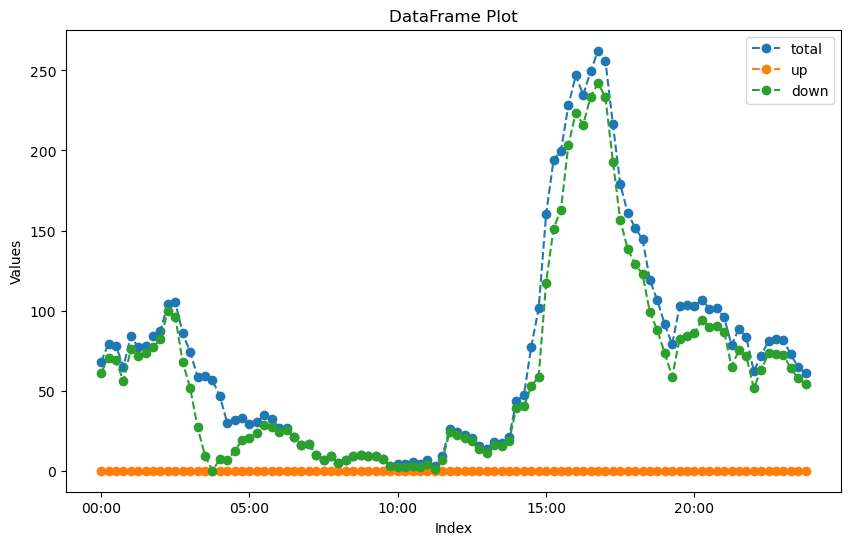

In [350]:
# from df_summed plot all the columns 

# Plot the DataFrame
plt.figure(figsize=(10, 6))

# Plot "car_" columns
# df_summed.filter(like='car_').plot(ax=plt.gca())

# Plot "total", "up", and "down"
df_summed[['total', 'up', 'down']].plot(ax=plt.gca(), linestyle='--', marker='o')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('DataFrame Plot')

# Show the plot
plt.legend()
plt.show()



In [130]:
columns_to_iterate = ['plug_in_time', 'be_charged', 'energy_needed', 'power']

df_final = pd.DataFrame(columns=['time', 'power'])

# Iterate over rows with selected columns
for index, row in df_test.iterrows():
    
    for column in columns_to_iterate:
        df = model_charging_average(datetime.strptime(row['plug_in_time'], "%H:%M"), datetime.strptime(row['be_charged'], "%H:%M"), row['energy_needed'], row['power'])
        if index == 0:
            df_final = df.copy()
        else:
            df_final["power"] = df_final["power"] + df["power"]


/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_51883/2037594963.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9584827586206895' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['time'] < round_end_time.time(), 'power'] = averaged_power
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_51883/2037594963.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.105142857142856' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['time'] >= round_start_time.time()) & (df['time'] < round_end_time.time()), 'power'] = averaged_power
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_51883/2037594963.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [287]:
def get_total_power_from_model(df):
    columns_to_iterate = ['plug_in_time', 'energy_needed', 'power']

    df_final = pd.DataFrame(columns=['time', 'power'])

    # Iterate over rows with selected columns
    for index, row in df_test.iterrows():
        for column in columns_to_iterate:
            df = model_charging(datetime.strptime(row['plug_in_time'], "%H:%M"), row['energy_needed'], row['power'])
            if index == 0:
                df_final = df.copy()
            else:
                df_final["power"] = df_final["power"] + df["power"]
    return df_final

In [288]:
df_final_normal = get_total_power_from_model(df_test)

In [282]:
df_final

,time,power,time_as_string
0,00:00:00,1555.739191,00:00
1,00:15:00,1606.459783,00:15
2,00:30:00,1666.763168,00:30
3,00:45:00,1764.434263,00:45
4,01:00:00,1826.914263,01:00
...,...,...,...
91,22:45:00,1318.770757,22:45
92,23:00:00,1379.824757,23:00
93,23:15:00,1403.767983,23:15
94,23:30:00,1479.606383,23:30


In [289]:
df_final_normal

,time,power
0,00:00:00,243
1,00:15:00,243
2,00:30:00,216
3,00:45:00,216
4,01:00:00,216
...,...,...
91,22:45:00,378
92,23:00:00,378
93,23:15:00,378
94,23:30:00,351


/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

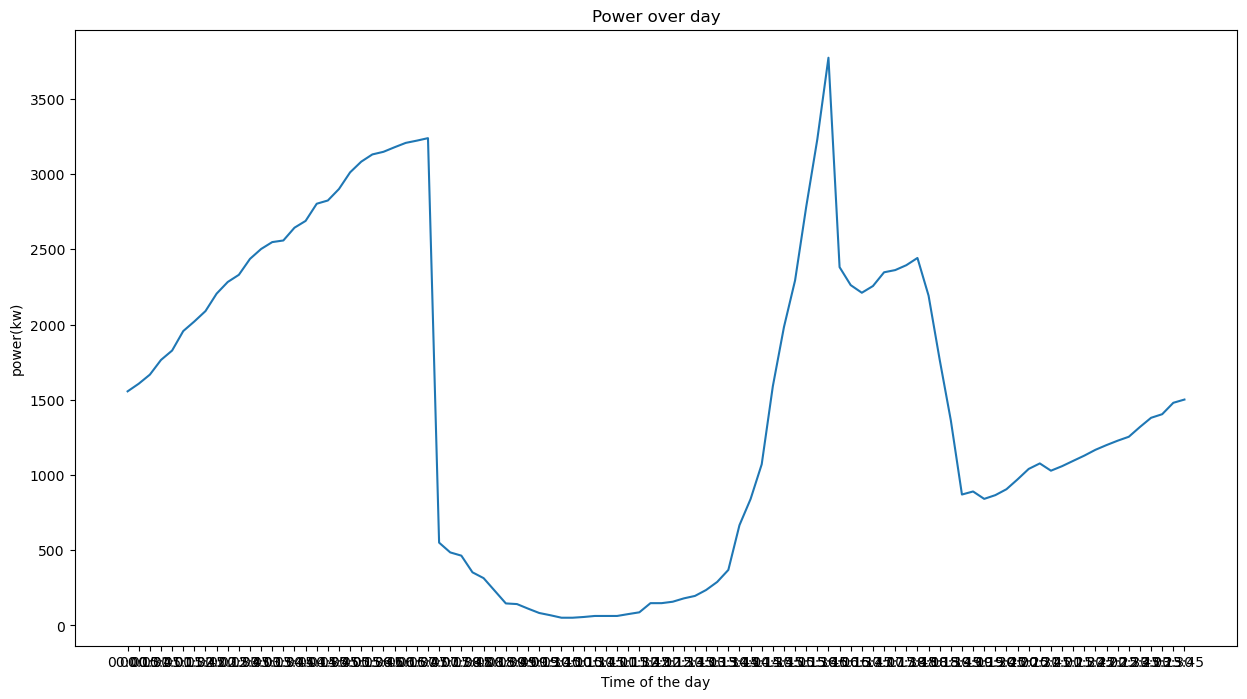

In [284]:
# plot power over day from df_final

df_final['time_as_string'] = df_final['time'].apply(lambda x: x.strftime('%H:%M'))

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final, x='time_as_string', y='power')
plt.xlabel('Time of the day')
plt.ylabel('power(kw)')
plt.title('Power over day')
plt.show()

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

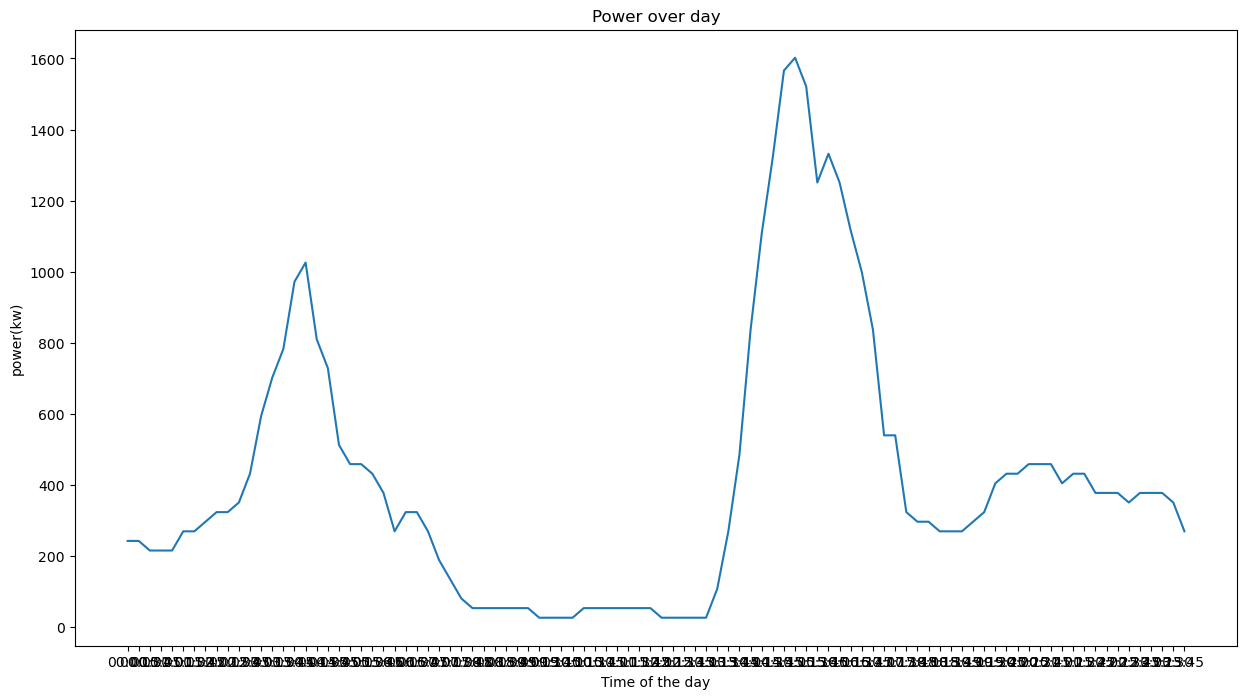

In [290]:
df_final_normal['time_as_string'] = df_final_normal['time'].apply(lambda x: x.strftime('%H:%M'))

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final_normal, x='time_as_string', y='power')
plt.xlabel('Time of the day')
plt.ylabel('power(kw)')
plt.title('Power over day')
plt.show()